
<table><tr>
    <td><img src="imagenes/Macc.png"/></td>
    <td><p style="font-size:18pt">Semillero de Modelación y Simulación de Fenómenos Sociales</p></td>
</tr></table>

<p align="right" style="font-size:10pt">Versión 2021-1</p>

# Simulación del Modelo del bar El Farol

## Descripción del juego iterativo

En el presente modelo se tiene una población de $N$ individuos, quienes deben tomar la decisión de si acudirán o no al bar llamado "El Farol". Cada agente toma esta decisión de manera independiente a los demás, y todos lo hacen de manera simultánea. 

<table><tr>
    <td><img src="imagenes/ElFarol1.jpeg"/></td>
    <td><img src="imagenes/ElFarol2.jpeg"/></td>
</tr></table>

Si el total de acudientes supera un umbral $\mu$, entonces El Farol se congestionará y los individuos que hayan ido no tendrán una buena experiencia (recompensa=-1). Por otro lado, si el total de los acudientes no supera este umbral, quienes hayan asistido podrán disfrutar de su estadía en el bar (recompensa=1). Adicionalmente, si un individuo no asiste al bar, será indiferente al estado de El Farol (recompensa=0). Cada agente intentará tomar la mejor decisión posible con respecto a asistir o no al bar. Esta situación se repetirá por un número $k$ de iteraciones. 

## Implementación en Python

#### AGENTES 

Los agentes que se simularán tendrán 2 atributos:

`estado`: Es la estrategia tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

`puntaje`: Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\mu $ determinado ($\mu=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\mu$ determinado ($\mu=0.5$).

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, `agente.estado[0]` es el estado del agente en la primera ronda.

Los agentes tendrán 2 métodos:

`toma_decision`(`modelo`, `parametros`): Es el método que le dice al agente qué estrategia seguir, la cual se decidirá de acuerdo al `modelo` seleccionado con los `parametros` dados.

`imprime_agente(r)`: imprime los datos del agente en la ronda `r`.

In [33]:
import pandas as pd
import seaborn as sns
from random import uniform
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.optimize import minimize, Bounds
from itertools import product

In [82]:
class Agente :
    
    def __init__(self, estados, puntajes, atractivos) :
        self.estado = estados # lista
        self.puntaje = puntajes # lista
        self.atractivo = atractivos # lista
        
    def toma_decision(self, modelo='aleatorio', parametros=[0.5], DEB=False) :
        '''
        Se lanza un "dado" para decidir aleatoriamente si el agente va o no al bar
        de acuerdo a si supera el umbral dado por el valor de para_ir
        '''
        atractivo=self.atractivo[-1] # Valor por defecto

        # determina el valor de para_ir de acuerdo al modelo y sus parámetros
        if modelo == 'aleatorio' :
            atractivo=parametros[0]
        
        if modelo == 'rescorla-wagner' :
            recompensa=(self.puntaje[-1]+1)/2
            alfa=parametros[0]
            atractivo=self.atractivo[-1]+alfa*(recompensa-self.atractivo[-1])

        # Actualiza el atractivo del agente
        self.atractivo.append(atractivo)
        
        # Lanza el dado
        if uniform(0,1) < atractivo :
            self.estado.append(1)
        else :
            self.estado.append(0)

    def imprime_agente(self, ronda) :
        try:
            estado = self.estado[ronda]
        except:
            estado = "nan"
        try:
            puntaje = self.puntaje[ronda]
        except:
            puntaje = "nan"
        try:
            atractivo = self.atractivo[ronda]
        except:
            atractivo = "nan"

        return "Estado:{0}, Puntaje:{1}, Atractivo:{2}".format(estado, puntaje, atractivo)
            

#### BAR

El bar será un objeto con los siguientes atributos:

`num_agentes`: cantidad de agentes que pueden ir al bar.

`agentes`: agentes que pueden ir al bar.

`umbral`: proporción de `agentes` que puede ir al bar para que la velada sea agradable.

`num_iteraciones`: cantidad de rondas.

`historia`: lista de la asistencia en todas las rondas pasadas.

El bar tendrá los siguientes métodos:

`calcular_asistencia()`: determina la cantidad de `agentes` que tomaron la decisión de ir al bar y actualiza la `historia`.

`calcular_puntajes()`: determina los puntajes de los `agentes` de acuerdo a la asistencia y a las decisiones respectivas. 

`agentes_deciden()`: solicita a los agentes que tomen una decisión.

`imprime_ronda(r)`: imprime la ronda `r`-ésima.

In [87]:
from random import randint, uniform
import numpy as np

class BarElFarol :
    
    def __init__(self, num_agentes, umbral, num_iteraciones, modelo='aleatorio', parametros=[.5]) :
        self.num_agentes = num_agentes
        self.umbral = umbral
        self.num_iteraciones = num_iteraciones
        self.historia = []
        self.agentes = []
        for i in range(self.num_agentes) :
            if modelo == 'aleatorio' :
                self.agentes.append(Agente([randint(0,1)], [], [parametros[0]]))        
            if modelo == 'rescorla-wagner' :
                self.agentes.append(Agente([randint(0,1)], [], [parametros[0], uniform(0,1)]))        
            
    def calcular_asistencia(self) :
        asistencia = np.sum([a.estado[-1] for a in self.agentes])
        self.historia.append(asistencia)

    def calcular_puntajes(self) :
        asistencia = self.historia[-1]/self.num_agentes
        for a in self.agentes:
            if a.estado[-1] == 1:
                if asistencia > self.umbral:
                    a.puntaje.append(-1)
                else:
                    a.puntaje.append(1)
            else:
                a.puntaje.append(0)

    def agentes_deciden(self, modelo='aleatorio', parametros=[0.5], DEB=False) :
        for a in self.agentes :
            a.toma_decision(modelo, parametros, DEB=DEB)
                
    def imprime_ronda(self, ronda) :
        try:
            asistencia = self.historia[ronda]
        except:
            asistencia = "nan"
        cadena = '='*30
        cadena += f"\nRonda: {ronda} || Asistencia: {asistencia}"
        for a in self.agentes:
            cadena += "\n" + a.imprime_agente(ronda)
        print(cadena)
        
    def guardar_pandas(self) :
        dict = {}
        ronda = []
        agentes = []
        estados = []
        puntajes = []
        atractivos = []
        for i in range(len(self.agentes)):
            a = self.agentes[i]
            ronda += [x for x in range(1, len(a.estado))]
            agentes += [i]*len(a.puntaje)
            estados += a.estado[:-1]
            puntajes += a.puntaje
            atractivos += a.atractivo[:-1]
        print(len(agentes), len(estados), len(puntajes), len(atractivos))
        dict['round'] = ronda
        dict['player'] = agentes
        dict['choice'] = estados
        dict['score'] = puntajes
        dict['motivated'] = atractivos
        return pd.DataFrame.from_dict(dict)

Con las funciones anteriores estamos listos para hacer la simulación, definiendo los parámetros iniciales:

In [84]:
def simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=1) :
    lista_dataframes = []
    for n in range(Nsim):
        bar=BarElFarol(
            num_agentes, 
            umbral, 
            num_iteraciones, 
            modelo=modelo, 
            parametros=parametros
        )        
        for t in range(num_iteraciones) : 
            bar.calcular_asistencia()
            bar.calcular_puntajes()
            bar.agentes_deciden(modelo=modelo,parametros=parametros,DEB=False)
        data = bar.guardar_pandas()
        data.sort_values(by=['round', 'player'], inplace=True)
        data['group'] = n
        data=data[['group','round','player','choice','score','motivated']]
        lista_dataframes.append(data)
    return pd.concat(lista_dataframes)

def visual(data_sim, data_obs) :
    data = pd.concat([data_sim,data_obs])
    attendance = pd.DataFrame(data.groupby(['source', 'group', 'round'])['choice'].sum().reset_index())
    attendance.columns = ['source', 'group', 'round', 'attendance']
    scores = pd.DataFrame(data.groupby(['source','group','player'])['score'].mean().reset_index())
    fig,ax=plt.subplots(1,2,figsize=(8,4))
    sns.lineplot('round', 'attendance', hue='source', data=attendance,ax=ax[0])
    sns.boxplot(data=scores, y='score', x='source', ax=ax[1])
    ax[0].set_title("Average attendance per round")
    ax[1].set_title("Distribution of average score")
    plt.tight_layout()

In [44]:
num_agentes=100
umbral=0.6
num_iteraciones=100
modelo='aleatorio'
p = 0.6
parametros = [p]

In [48]:
data_sim = simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
data_sim.head()

,group,round,player,choice,score,motivated
0,0,1,0,0,0,0.6
100,0,1,1,1,1,0.6
200,0,1,2,0,0,0.6
300,0,1,3,0,0,0.6
400,0,1,4,1,1,0.6


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='round', ylabel='attendance'>

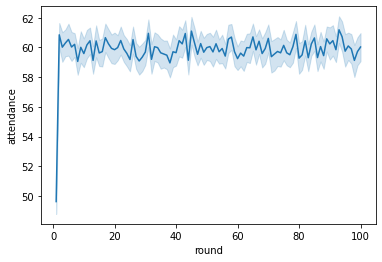

In [47]:
attendance = pd.DataFrame(data_sim.groupby(['group','round'])['choice'].sum().reset_index())
attendance.columns = ['group','round','attendance'] 
sns.lineplot('round','attendance',data=attendance)

In [46]:
data_sim.to_csv('random_agents.csv', index=False)

In [85]:
num_agentes=100
umbral=0.6
num_iteraciones=100
modelo='rescorla-wagner'
p = 0.6
alpha = 0.01
parametros = [alpha]

In [88]:
data_sim = simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
data_sim.head()

10000 10000 10000 10100


ValueError: arrays must all be same length

In [ ]:
attendance = pd.DataFrame(data_sim.groupby(['group','round'])['choice'].sum().reset_index())
attendance.columns = ['group','round','attendance'] 
sns.lineplot('round','attendance',data=attendance)